In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from IPython import display
display.set_matplotlib_formats('svg')

from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

/var/folders/nn/4_714bpd2qz7gm9d27_r3qw40000gn/T/ipykernel_60515/3438048521.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
iris = sns.load_dataset('iris')

In [3]:
data = torch.tensor(iris[iris.columns[0:4]].values).float()

labels = torch.zeros(len(data), dtype = torch.long)

labels[iris.species == 'virginica'] == 2
labels[iris.species == 'versicolor'] == 1

labels.shape

torch.Size([150])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2, random_state = 42)

train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

batchSize = int(train_data.tensors[0].shape[0]/4)

train_loader = DataLoader(train_data, shuffle = True, batch_size = batchSize)
test_loader = DataLoader(test_data, batch_size = test_data.tensors[0].shape[0])

In [27]:
for X, y in train_loader:
    print(X.shape, y.shape)

torch.Size([30, 4]) torch.Size([30])
torch.Size([30, 4]) torch.Size([30])
torch.Size([30, 4]) torch.Size([30])
torch.Size([30, 4]) torch.Size([30])


In [28]:
def create_model():
    ANNIris = nn.Sequential(
        nn.Linear(4, 64),
        nn.ReLU(),
        nn.Linear(64, 64),
        nn.ReLU(),
        nn.Linear(64, 3)
    )
    
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(ANNIris.parameters(), lr = 0.1)
    return ANNIris, lossfun, optimizer

In [29]:
model, lossfun, optimizer = create_model()

In [30]:
for i in model.named_parameters():
    print(i[0], i[1].shape, i[1].numel())

0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [31]:
numepochs = 1000

def train_model(L1lambda):
    train_acc = []
    test_acc = []
    losses = []
    # count the total number of weights in the model
    nweights = 0
    for pname,weight in model.named_parameters():
        if 'bias' not in pname:
            nweights = nweights + weight.numel()

    
    for epochi in range(numepochs):
        batch_acc = []
        batch_loss = []
        
        for X, y in train_loader:
            yHat = model(X)
            loss = lossfun(yHat, y)
            ### add L1 term
            L1_term = torch.tensor(0.,requires_grad=True)

            # sum up all abs(weights)
            for pname,weight in model.named_parameters():
                if 'bias' not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))
      
            # add to loss term
            loss = loss + L1lambda*L1_term/nweights
      
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            predLabels = torch.argmax(yHat, axis = 1)
            acc = 100 * torch.mean((predLabels == y).float())
            batch_acc.append(acc)
            batch_loss.append(loss.item())
            
        train_acc.append(np.mean(batch_acc))
        losses.append(np.mean(batch_loss))
        
        model.eval()
        X, y = next(iter(test_loader))
        yHat = model(X)
        predLabels = torch.argmax(yHat, axis = 1)
        acc = 100 * torch.mean((predLabels == y).float())
        test_acc.append(acc)
        model.train()
    
    return train_acc, test_acc, losses

In [32]:
L1lambda = 0.02
train_acc, test_acc, losses = train_model(L1lambda)

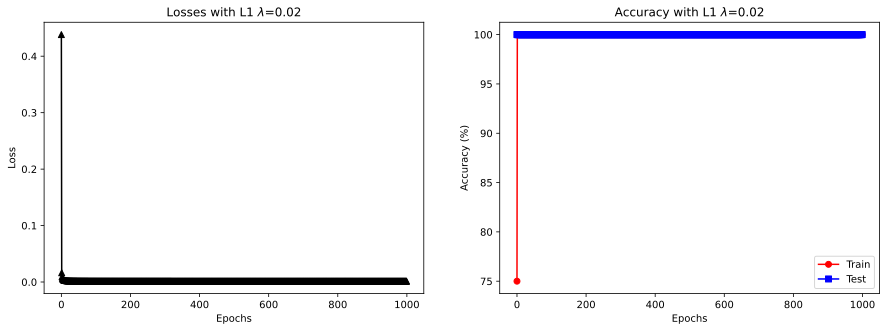

In [33]:
# plot the results
fig,ax = plt.subplots(1,2,figsize=(15,5))


ax[0].plot(losses,'k^-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Losses with L1 $\lambda$=' + str(L1lambda))

ax[1].plot(train_acc,'ro-')
ax[1].plot(test_acc,'bs-')
ax[1].set_title('Accuracy with L1 $\lambda$=' + str(L1lambda))
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend(['Train','Test'])

plt.show()

In [34]:
# create a 1D smoothing filter
def smooth(x,k):
  return np.convolve(x,np.ones(k)/k,mode='same')

In [ ]:
L1lambda = np.linspace(0, 0.1, 10)

trainAccResults = np.zeros((numepochs, len(L2lambda)))
testAccResults = np.zeros((numepochs, len(L2lambda)))

for li in range(len(L2lambda)):
    model, lossfun, optimizer = create_model(L2lambda[li])
    train_acc, test_acc, losses = train_model(model, lossfun, optimizer)
    
    trainAccResults[:, li] = smooth(train_acc, 10)
    testAccResults[:, li] = smooth(test_acc, 10)
 